In [291]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [292]:
# Download dataset containing thousand images of pandas and polar bears scraped from Google, Bing and Baidu.
_URL = 'https://media.githubusercontent.com/media/zhou997/image_classification/main/pandas_and_polar_bears.zip'
path_to_zip = tf.keras.utils.get_file('pandas_and_polar_bears.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'pandas_and_polar_bears')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32

# The model EfficientNetB0 takes input images of shape (224, 224, 3), and the input data should range [0, 255].
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Found 1363 files belonging to 2 classes.


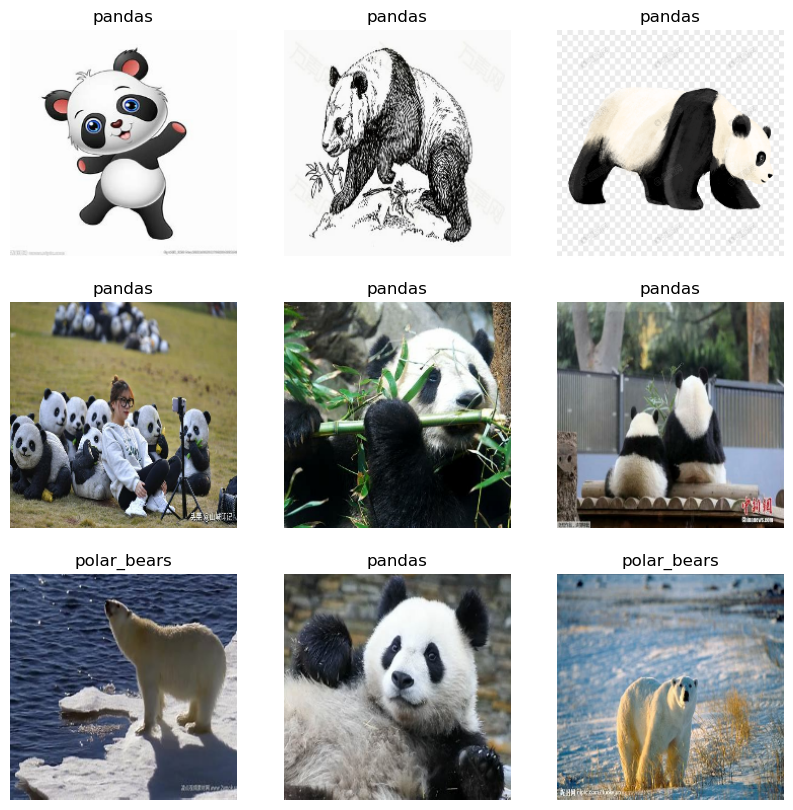

In [307]:
class_names = train_dataset.class_names

# Draw the first 9 images with lable from train_dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [308]:
# Create a test_dataset by moving 20% from the validation set.
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 8


In [309]:
AUTOTUNE = tf.data.AUTOTUNE

# Load images use buffered prefetching, decouple the time when data is produced from the time when data is consumed.
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [310]:
# Use the Keras preprocessing layers for data augmentation to reduce overfitting.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

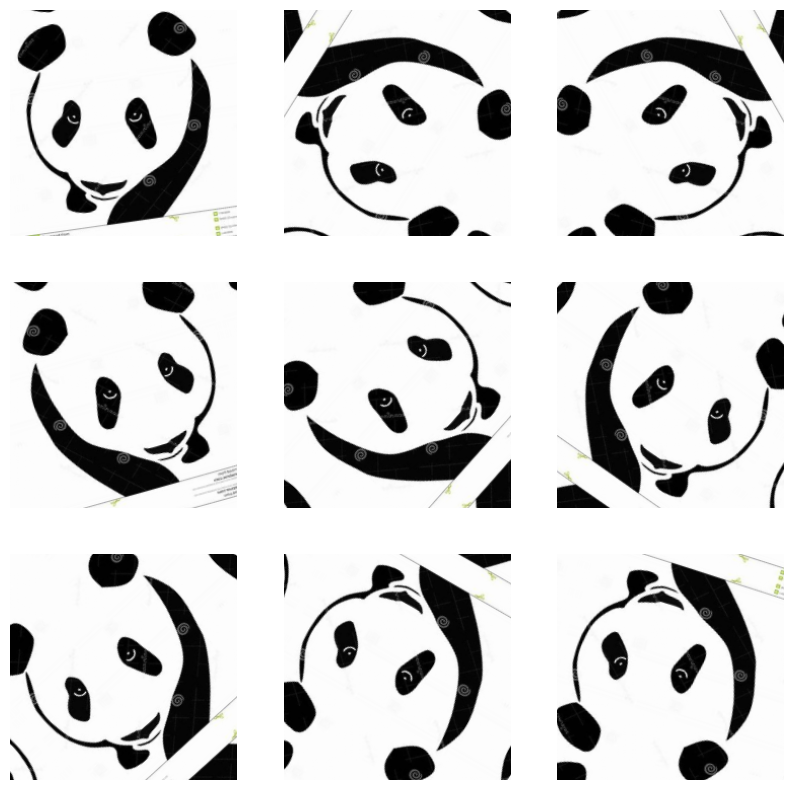

In [311]:
# See what data_augmentation function does to the first image.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [312]:
#(224, 224, 3).
IMG_SHAPE = IMG_SIZE + (3,)

# Create a base model from the pre-trained model EfficientNet
# Disable the classification layers at the top for eature extraction
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))

In [313]:
# Feature extraction
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze all layers and train only the top layers, to prevents the weights in a given layer from being updated during training.
base_model.trainable = False

# Convert the features to a single 1280-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Convert features into a single prediction per image by Dense Layer.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 224, 224, 3)
(32, 7, 7, 1280)
(32, 1280)
(32, 1)


In [314]:
#Build a model.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [315]:
# Compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
print(len(model.trainable_variables))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1281      
                                                           

In [316]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

35/35 [==============================] - 50s 1s/step - loss: 0.7233 - accuracy: 0.4824
initial loss: 0.72
initial accuracy: 0.48


In [317]:
# First training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
94/94 [==============================] - 197s 2s/step - loss: 0.6097 - accuracy: 0.6357 - val_loss: 0.5092 - val_accuracy: 0.7814
Epoch 2/10
94/94 [==============================] - 193s 2s/step - loss: 0.4496 - accuracy: 0.8213 - val_loss: 0.3859 - val_accuracy: 0.8961
Epoch 3/10
94/94 [==============================] - 190s 2s/step - loss: 0.3520 - accuracy: 0.8913 - val_loss: 0.3134 - val_accuracy: 0.9178
Epoch 4/10
94/94 [==============================] - 190s 2s/step - loss: 0.2891 - accuracy: 0.9127 - val_loss: 0.2637 - val_accuracy: 0.9332
Epoch 5/10
94/94 [==============================] - 190s 2s/step - loss: 0.2494 - accuracy: 0.9270 - val_loss: 0.2309 - val_accuracy: 0.9359
Epoch 6/10
94/94 [==============================] - 193s 2s/step - loss: 0.2195 - accuracy: 0.9357 - val_loss: 0.2028 - val_accuracy: 0.9503
Epoch 7/10
94/94 [==============================] - 192s 2s/step - loss: 0.1977 - accuracy: 0.9390 - val_loss: 0.1821 - val_accuracy: 0.9485
Epoch 8/10
94

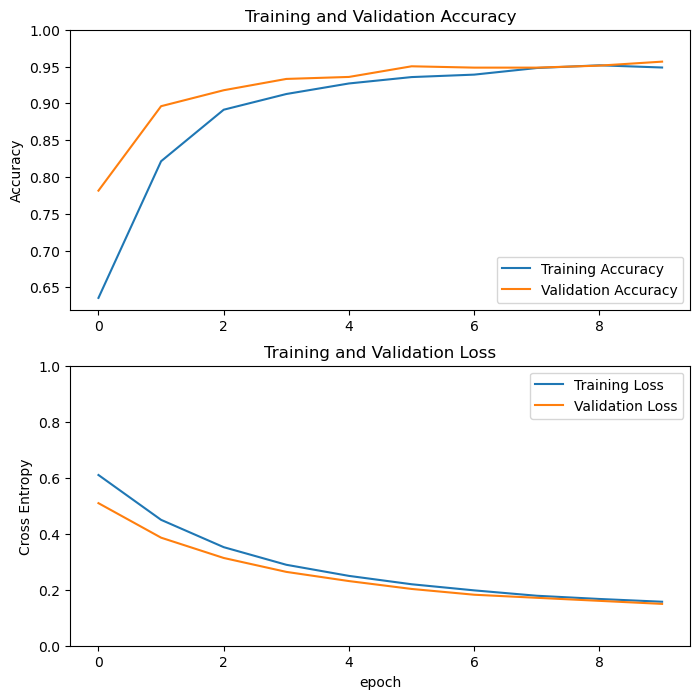

In [318]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [319]:
# Transfer learning from pre-trained weights.
# Unfreeze a number of layers and fit the model using smaller learning rate.
base_model.trainable = True

# Show how many layers are in the base model.
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  238


In [320]:
# Fine-tune from this layer onwards
fine_tune_at = 180

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
print('Trainable_variables: ', len(model.trainable_variables))

Trainable_variables:  54


In [321]:
# Second training
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
94/94 [==============================] - 240s 2s/step - loss: 0.1469 - accuracy: 0.9433 - val_loss: 0.1116 - val_accuracy: 0.9630
Epoch 11/20
94/94 [==============================] - 238s 3s/step - loss: 0.1052 - accuracy: 0.9603 - val_loss: 0.0969 - val_accuracy: 0.9612
Epoch 12/20
94/94 [==============================] - 245s 3s/step - loss: 0.0903 - accuracy: 0.9633 - val_loss: 0.0948 - val_accuracy: 0.9648
Epoch 13/20
94/94 [==============================] - 245s 3s/step - loss: 0.0737 - accuracy: 0.9710 - val_loss: 0.0852 - val_accuracy: 0.9675
Epoch 14/20
94/94 [==============================] - 240s 3s/step - loss: 0.0669 - accuracy: 0.9723 - val_loss: 0.0767 - val_accuracy: 0.9738
Epoch 15/20
94/94 [==============================] - 242s 3s/step - loss: 0.0602 - accuracy: 0.9773 - val_loss: 0.0812 - val_accuracy: 0.9702
Epoch 16/20
94/94 [==============================] - 243s 3s/step - loss: 0.0564 - accuracy: 0.9780 - val_loss: 0.0733 - val_accuracy: 0.9747
Epoch 

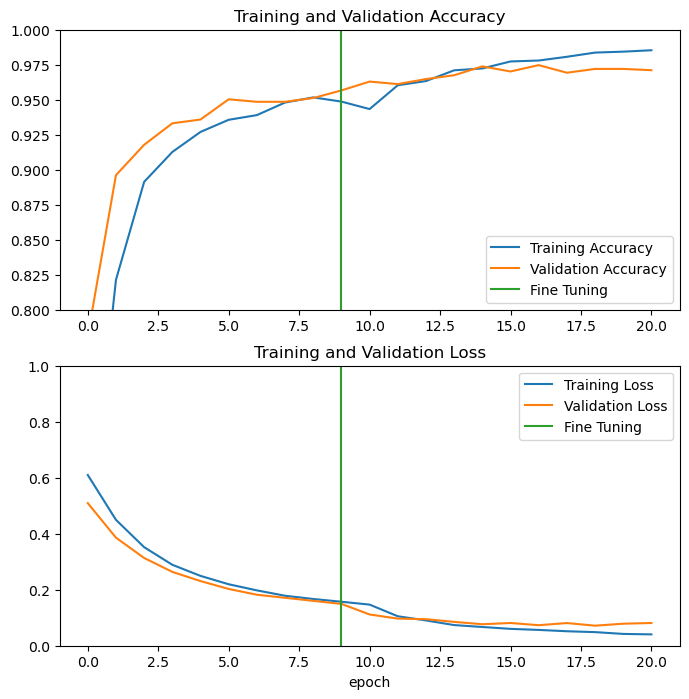

In [322]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [323]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 10s 1s/step - loss: 0.0380 - accuracy: 0.9766
Test accuracy : 0.9765625


Predictions:
 [1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1]
Labels:
 [1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1]


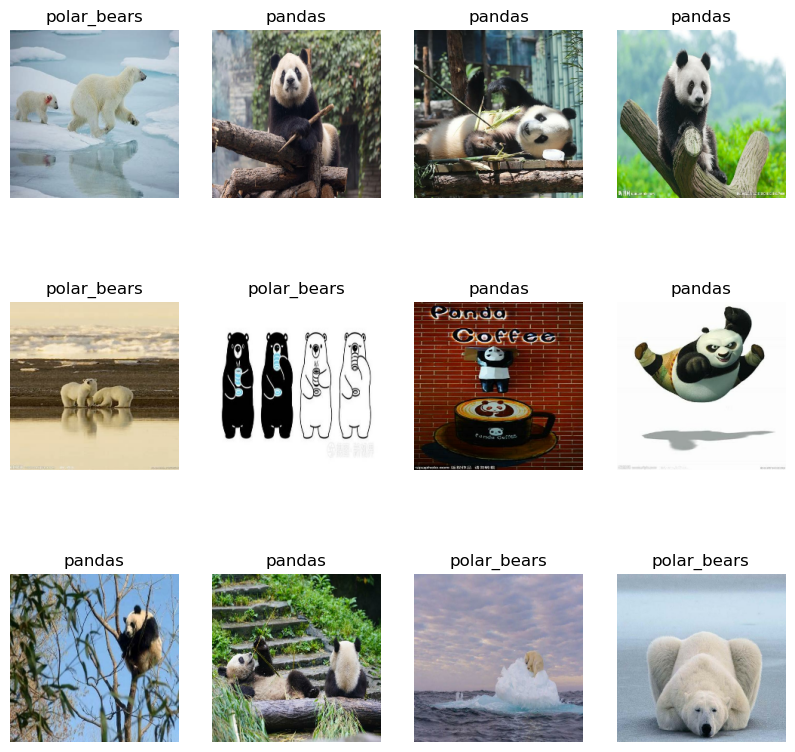

In [328]:
# Retrieve images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")